## Bulldozers random Forest

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
# path is direction to bulldozers data

In [4]:
PATH = "data/bulldozers/all/"

In [5]:
# reading dataset 


In [6]:
# dtype of saledate is date thts the reason we use parse_dates
# train
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=["saledate"])
# test
df_test = pd.read_csv(f'{PATH}/Test.csv', low_memory=False, parse_dates=['saledate'])

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
#display_all(df_raw.tail().T)

In [9]:
#display_all(df_raw.describe(include='all').T)

In [10]:
# kaggle use RMSLE (root mean squared log error)

In [11]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [12]:
# add_datepart to add all data out of column date that we define from parsdate in begining

In [13]:
# train
add_datepart(df_raw, 'saledate')
# test
add_datepart(df_test, 'saledate')

In [14]:
# train_cats to convert strings to pandas categories

In [15]:
train_cats(df_raw)

In [16]:
# test
apply_cats(df_test,df_raw)

In [17]:
# We can specify the order to use for categorical variables 

In [18]:
# train
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [20]:
# Test
df_test.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [21]:
# replace Usageband col by usageband codes
# Train
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [22]:
# Train
df_test.UsageBand = df_test.UsageBand.cat.codes

In [23]:
# dispalying missing values,

In [24]:
# display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

In [25]:
# We'll replace categories with their numeric codes, handle missing continuous values, 
# and split the dependent variable into a separate variable.

In [26]:
# Train
X, y, nas = proc_df(df_raw, 'SalePrice')

In [27]:
# Test
X_test, _, nas = proc_df(df_test, na_dict=nas)

In [28]:
X, y , nas = proc_df(df_raw, 'SalePrice', na_dict=nas)

In [29]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X, y)
m.score(X,y)

0.9830241981800025

In [30]:
# R^2 ia .983

In [31]:
# Split the dataset into Training and Validation dataset

In [33]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(X)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [34]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [35]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 7s, sys: 212 ms, total: 1min 7s
Wall time: 13.4 s
[0.0905490275502126, 0.24709333603849895, 0.9828642780221948, 0.8909639676611623]


In [36]:
#An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 
#on the Kaggle leaderboard), but we can see from the validation set score that
#we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

In [37]:
## Single tree

In [38]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5371269683343529, 0.5674541015387254, 0.39703966649954636, 0.4249449087371987]


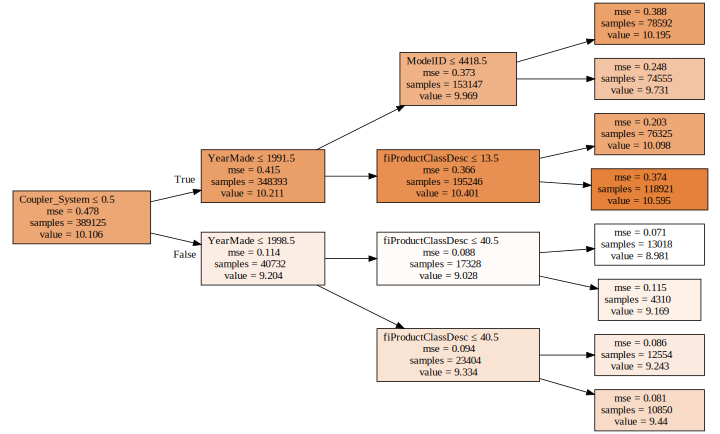

In [39]:
draw_tree(m.estimators_[0], X_train, precision=3)

In [40]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[8.58675118495947e-07, 0.35067277115706164, 0.999999999998459, 0.7803900239102883]


In [41]:
#bagging when n_estimators is greater than 1

In [42]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09055851476319483, 0.249744471010344, 0.9828606870667755, 0.8886116582351536]


In [43]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.25913, 9.21034, 9.43348, 9.25913, 9.21034, 9.10498, 8.95545, 9.10498, 9.10498, 9.15905]),
 9.180186050842508,
 9.104979856318357)

In [44]:
preds.shape

(10, 12000)

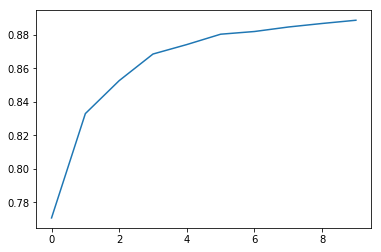

In [45]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [46]:
#The shape of this curve suggests
#that adding more trees (more than 8) isn't going to help us much. 
#Let's check. (Compare this to our original model on a sample)

In [47]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.08262533218307583, 0.24005250311741047, 0.9857320603694005, 0.8970893190848815]


In [48]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.07836834563074388, 0.2408335907810032, 0.98716439972865, 0.8964185238464915]


In [49]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0760852806871794, 0.23453343102017013, 0.9879013720900774, 0.901766981801806]


In [50]:
### Out-of-bag (OOB) score

In [51]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07834558592067957, 0.2382954953071044, 0.987171854067963, 0.8985902670178951, 0.9085596676739425]


In [52]:
## Reducing over-fitting


In [ ]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [ ]:
set_rf_samples(20000)

In [ ]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
# another way to reduce overftiing

In [ ]:
reset_rf_samples()

In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [53]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11922640444961354, 0.2277480529585634, 0.9702915687143115, 0.9073687937175757, 0.9115909005095856]


In [ ]:
# Submiting to kaggle

In [59]:
# Get predictions on processed test dataset.
predictions = m.predict(X_test)

In [61]:
submission = pd.DataFrame({'SalesID': df_test.SalesID, 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)